In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
import auth
import getpass

user  = getpass.getuser()
token = auth.get_valid_token()

In [100]:
import trino
import os
connection = trino.dbapi.connect(
    host=os.environ['PRESTO_HOST'],
    port=443,
    user=user,
    catalog="hive",
    schema="dwh_insider",
    http_scheme='https',
    auth=trino.auth.BasicAuthentication(user, token))

In [101]:
# Taking the claim information from the datalake
query = """
WITH claim_query as 
(
SELECT

       carrier_tracking_number
      , claim_shipment_number
      , sk_claim_report_date
      , aviailable_claim_amount_euro
      , net_claim_amount_euro
      , carrier_name
      , carrier_name_short
      , country_code 
      , sk_shipping_country as country
      , claimtype
      , cast(sk_month as int) as sk_month
      , SK_WEEK
      , claimsubtype
      , manual_refund_reason_name
      , claim_category
      , dd.ZIP
      , dd.city
      , TS_LAST_COT_EVENT
      , TS_LAST_CRT_EVENT
      , unplanned_return_flag 
      , reconditioned_claim_flag 
      , CASE WHEN chan.sk_cfa in (31, 26) THEN 'FashionStore'
             WHEN chan.sk_cfa = 28 THEN 'Lounge' END AS cfa -- 26 is empty for recent periods, it stands for zlash
      ,CASE WHEN carrier_name='n/a' THEN claimsubtype
            ELSE carrier_name END AS carrier
FROM
    dwh_confidential.f_clm_claim_shipments as fccs
LEFT JOIN
          dwh_insider.d_clm_carrier_liability as dccl
          ON dccl.sk_clm_carrier_liability = fccs.sk_clm_carrier_liability
LEFT JOIN
          dwh_insider.d_network_carriers as dnc
          ON dnc.sk_network_carrier = fccs.sk_network_carrier
LEFT JOIN
          dwh_insider.d_sf_carrier_claim_types as dscct
          ON dscct.sk_claim_type = fccs.sk_claim_type
LEFT JOIN
          dwh_insider.d_clm_claim_categories as dccc
          ON dccc.sk_claim_category = fccs.sk_claim_category
LEFT JOIN
          dwh_insider.d_manual_refund_reason AS dmrr
          ON dmrr.sk_manual_refund_reason = fccs.sk_manual_refund_reason
LEFT JOIN
          dwh_confidential.D_DESTINATIONS AS dd
          ON fccs.SK_DESTINATION = dd.SK_DESTINATION
LEFT JOIN
          dwh_insider.d_sales_channels AS chan
          ON fccs.sk_sales_channel = chan.sk_sales_channels 
LEFT JOIN 
          dwh_insider.d_date as d
          ON d.sk_date=fccs.sk_claim_report_date
          
WHERE  chan.sk_cfa in (31, 26, 28)
)
SELECT 
       COUNT(DISTINCT claim_shipment_number) as number_of_claims,
       SUM(aviailable_claim_amount_euro) as claims_amount ,
       country_code , 
       sk_month,
       carrier,
       ZIP,
       city,
       unplanned_return_flag,
       reconditioned_claim_flag 
       
FROM claim_query
 WHERE 

   claimtype='Delivery'
   
    AND 
     cfa = 'FashionStore'
      AND 
      sk_month Between 202201 AND 202212
GROUP BY 
         sk_month , 
         country_code,
         carrier,
         ZIP,
         city,   
         unplanned_return_flag,
         reconditioned_claim_flag
         
   """
df = pd.read_sql_query(query, connection)
df  

/tmp/ipykernel_1796/2270083925.py:91: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,number_of_claims,claims_amount,country_code,sk_month,carrier,ZIP,city,unplanned_return_flag,reconditioned_claim_flag
0,3,190.3400000,FR,202207,LA POSTE,69780,Mions,0,0
1,1,5.8310000,SE,202212,POSTNORD,57274,PÅSKALLAVIK,0,0
2,1,1.7361000,ES,202204,DHL,48113,Gamiz Fika,0,0
3,1,56.1600000,ES,202204,CELERITAS,48270,Markina-Xemein,0,0
4,3,268.8100000,DE,202211,DHL,13409,Berlin,0,0
...,...,...,...,...,...,...,...,...,...
272493,1,238.5700000,DE,202210,DHL,10117,Berlin,0,0
272494,1,47.8300000,ES,202211,CELERITAS,12410,Altura,1,1
272495,1,91.6300000,FR,202206,LA POSTE,38890,St Chef,0,0
272496,1,445.0500000,DE,202204,DHL,82393,Iffeldorf,0,0


In [102]:
df['claims_amount']=df['claims_amount'].astype(float)

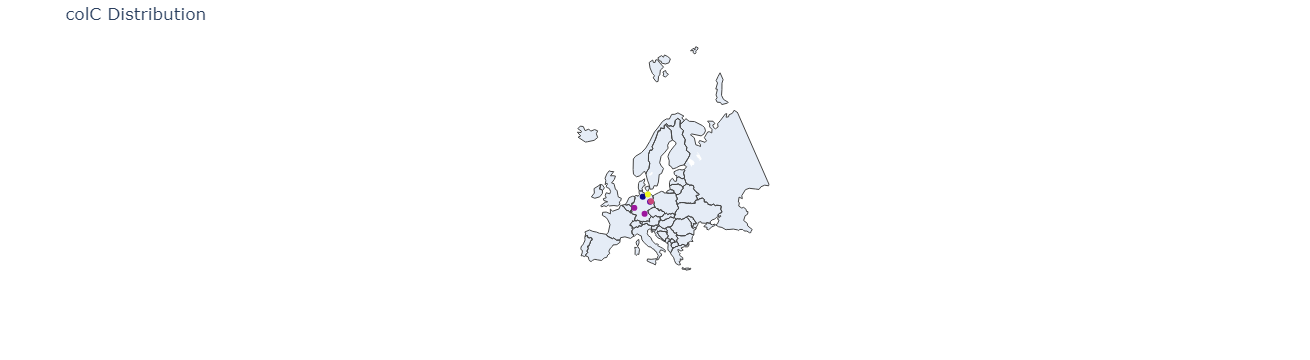

In [103]:

import pandas as pd
import pandas_bokeh
import matplotlib.pyplot as plt
import pgeocode
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

import plotly.graph_objects as go
## Adding some dummy data 
nomi = pgeocode.Nominatim('de')
d = {'colC': ['val1','val2','val3','val2','val2','val4','val5'], 'zipcode': ['22111','53119','14473','90459', '10243','18001','18147'],'count':[1,3,2,3,4,6,7]}
edf = pd.DataFrame(data=d)
edf
edf['Latitude'] = (nomi.query_postal_code(edf['zipcode'].tolist()).latitude)
edf['Longitude'] = (nomi.query_postal_code(edf['zipcode'].tolist()).longitude)
fig = go.Figure(data=go.Scattergeo(
        lon = edf['Longitude'],
        lat = edf['Latitude'],
        text = edf['colC'],
        mode = 'markers',
        marker_color = edf['count']
        ))

fig.update_layout(
        title = 'colC Distribution',
        geo_scope='europe',
    margin=dict(l=40, r=40, t=40, b=40)
    )
fig.show()

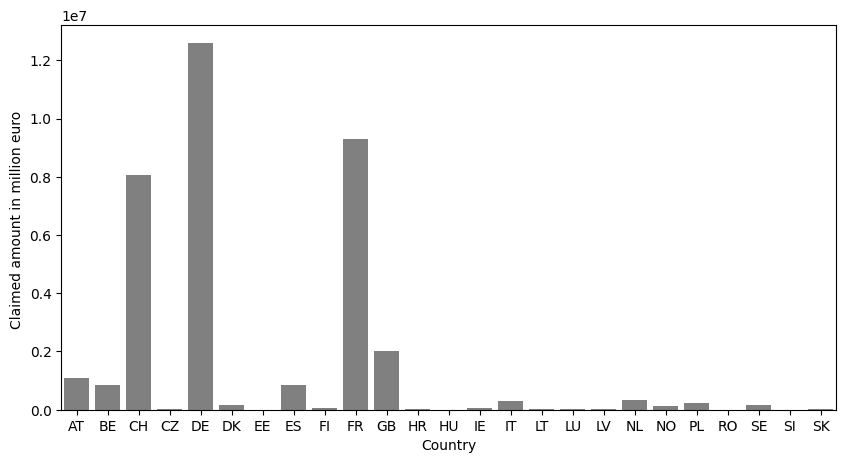

In [75]:
group_country=df.groupby(['country_code'], as_index=True)['claims_amount'].sum()
group_country=group_country.reset_index()
fig, ax = plt.subplots(figsize=(10,5))
ax=sns.barplot(data=group_country, x="country_code", y="claims_amount",color='gray')
ax.set_ylabel('Claimed amount in million euro ')    
ax.set_xlabel('Country')
plt.show()

In [ ]:
group_country_uk=df[df['country_code']=='GB']
group_country_uk['carriers'] = group_country_uk.loc[:,('carrier')].apply(lambda x: 'Evri' if x in ('HERMES','HMS')   else 'YODEL')
group_country_uk=group_country_uk.groupby(['sk_month','carriers'], as_index=True).agg({'claims_amount':sum,'number_of_claims':sum})
group_country_uk=group_country_uk.reset_index()

group_country_uk['carriers'] =group_country_uk['carriers'].str.upper()
group_country_uk

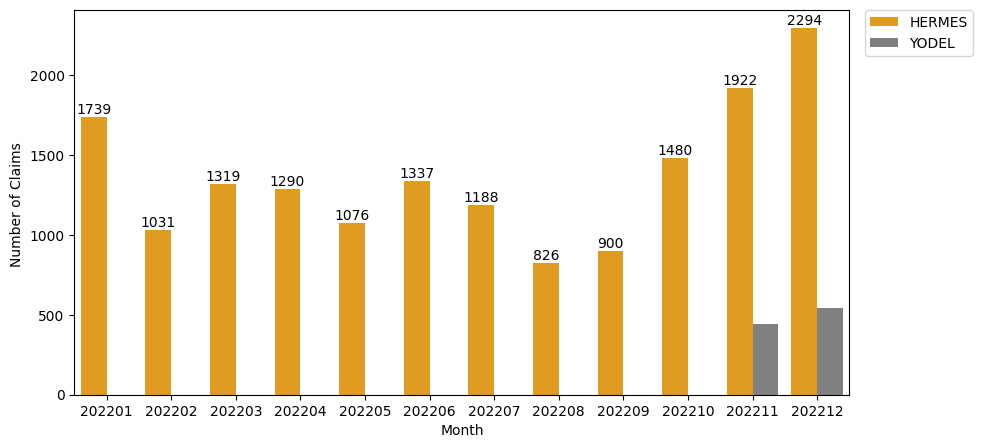

In [77]:
group_country_uk['sk_month']=group_country_uk['sk_month'].astype(str)
fig, ax = plt.subplots(figsize=(10,5))

ax=sns.barplot(data=group_country_uk, x="sk_month", y="number_of_claims",palette=["orange", "gray"],hue='carriers',errorbar=None)
ax.set_ylabel('Number of Claims ')    
ax.set_xlabel('Month')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

In [78]:
# Taking the claim information from the datalake
query = """
with ffsoi_base as (
        select

                        ffsoi.shipment_id, ffsoi.ts_est_delivery_from, ffsoi.ts_est_delivery_to,
                        ffsoi.sk_order_type, ffsoi.sk_logistic_provider, ffsoi.sk_order_date,
                        ffsoi.full_cancellation_flag, ffsoi.sk_selected_fulfill_service,
                        ffsoi.sk_delivery_type, ffsoi.sk_sales_channel, ffsoi.sk_destination,
                        ffsoi.sk_wmo_flag, ffsoi.shipment_has_ldd, ffsoi.sk_stock_location_id,
                        ffsoi.sk_carrier,

                        fccs.ts_first_delivery_attempt, fccs.sk_customer_delivery_date,
                        fccs.ts_customer_delivery,
                        fccs.lt_min_order_to_fda_wo_sun, fccs.lt_min_order_to_fda_wo_wend,
                        fccs.sk_delivery_cluster_wo_sun, fccs.is_prepayment_shipment,

                        fccs.is_delivered_too_early,
                        fccs.is_delivered_two_days_earlier,
                        fccs.is_delivered_a_day_earlier,
                        fccs.is_delivered_as_promised,
                        fccs.is_home_target,
                        fccs.is_pickup_point_target,
                        fccs.is_delivered_to_home,
                        fccs.is_delivered_to_pickup_point,

                        coalesce(ffsoi.sk_carrier, fccs.sk_carrier) as sk_carrier,
                        coalesce(ffsoi.sk_delivery_product, fccs.sk_delivery_product) as sk_delivery_product,

                        f_serv.fulfillment_service,
                        d_serv.service_name,
                        d_prod_serv.service_name as del_serv,
                        chan.sk_cfa,
                        country.destination_country,
                        logistic.logistic_provider_name,
                        logistic.logistic_provider,
                        stock.warehouse_name,
                        carr.carrier_description,
                        d_prod.sk_delivery_service,
                        d_prod.sk_delivery_carrier,
                        case when chan.sk_cfa in (31, 26) then 'FS'
                             when chan.sk_cfa = 28 then 'Lounge' end as cfa -- 26 is empty for recent periods, it stands for zlash


        from

                      (select shipment_id,
                              min(ts_est_delivery_from) as ts_est_delivery_from,
                              min(ts_est_delivery_to) as ts_est_delivery_to,
                              max(sk_order_type) as sk_order_type,
                              max(sk_logistic_provider) as sk_logistic_provider,
                              max(sk_order_date) as sk_order_date,
                              max(full_cancellation_flag) as full_cancellation_flag,
                              max(sk_selected_fulfill_service) as sk_selected_fulfill_service,
                              max(sk_delivery_type) as sk_delivery_type,
                              max(sk_sales_channel) as sk_sales_channel,
                              max(sk_destination) as sk_destination,
                              max(sk_wmo_flag) as sk_wmo_flag,
                              max(sk_stock_location_id) as sk_stock_location_id,
                              max(is_long_distance_item) as shipment_has_ldd,
                              max(sk_carrier) as sk_carrier,
                              max(sk_delivery_product) as sk_delivery_product
                      from dwh_confidential.f_fos_shipment_order_items
                      where sk_order_date between  20220101 and 20221231
                      group by shipment_id ) as ffsoi

                      -- For calculated lead times [sk_delivery_cluster_wo_sun, lt_min_order_to_fda_wo_sun,
                      -- lt_min_order_to_fda_wo_wend]
                      left join (select shipment_id, 
                                        max(ts_first_delivery_attempt) as ts_first_delivery_attempt,
                                        max(sk_first_delivery_attempt_date) as sk_first_delivery_attempt_date,
                                        max(ts_customer_delivery) as ts_customer_delivery,
                                        max(sk_customer_delivery_date) as sk_customer_delivery_date,
                                        max(lt_min_order_to_fda_wo_sun) as lt_min_order_to_fda_wo_sun,
                                        max(lt_min_order_to_fda_wo_wend) as lt_min_order_to_fda_wo_wend,
                                        max(sk_delivery_cluster_wo_sun) as sk_delivery_cluster_wo_sun,
                                        max(sk_carrier) as sk_carrier,
                                        max(sk_delivery_product) as sk_delivery_product,
                                        max(is_delivered_too_early) as is_delivered_too_early,
                                        max(is_delivered_two_days_earlier) as is_delivered_two_days_earlier,
                                        max(is_delivered_a_day_earlier) as is_delivered_a_day_earlier,
                                        max(is_delivered_as_promised) as is_delivered_as_promised,
                                        max(is_prepayment_shipment) as is_prepayment_shipment,
                                        max(is_home_target) as is_home_target,
                                        max(is_pickup_point_target) as is_pickup_point_target,
                                        max(is_delivered_to_home) as is_delivered_to_home,
                                        max(is_delivered_to_pickup_point) as is_delivered_to_pickup_point
                                 from dwh_confidential.f_cot_carrier_shipments
                                 where sk_min_order_created_date between 20220101 and 20221231
                                 group by shipment_id ) as fccs
                                 on ffsoi.shipment_id = fccs.shipment_id

                      -- For delivery service [sk_delivery_carrier]
                      left join dwh_insider.d_delivery_products d_prod
                                on coalesce(ffsoi.sk_delivery_product, fccs.sk_delivery_product) = d_prod.sk_delivery_product

                      -- for carrier name [carrier_name]
                      left join dwh_insider.d_delivery_carriers carr
                                on d_prod.sk_delivery_carrier = carr.sk_delivery_carrier

                      -- For selected fulfillment service [fulfillment_service]
                      left join dwh_insider.d_shp_fulfillment_services f_serv
                                on ffsoi.sk_selected_fulfill_service = f_serv.sk_fulfillment_service

                      -- For delivery service [service_name]
                      left join dwh_insider.d_delivery_services d_serv
                                on ffsoi.sk_delivery_type = d_serv.sk_delivery_service

                      -- For delivery service [service_name]
                      left join dwh_insider.d_delivery_services d_prod_serv
                                on d_prod.sk_delivery_service = d_prod_serv.sk_delivery_service

                      -- For filtering for shop [sk_cfa]
                      left join dwh_insider.d_sales_channels chan
                                on ffsoi.sk_sales_channel = chan.sk_sales_channels

                      -- For getting destination country [country_code]
                      left join (select sk_destination, max(sk_shipping_country) as sk_country
                                 from dwh_confidential.d_destinations
                                 group by 1) as dest
                                on ffsoi.sk_destination = dest.sk_destination

                      -- For filtering Zalando fulfillment [fulfillment_type, warehouse_name]
                      left join dwh_insider.d_stock_location_bp as stock
                                on ffsoi.sk_stock_location_id = stock.sk_stock_location

                      -- For getting destination country [destination_country]
                      left join (select sk_country, country_name_short_en as destination_country
                                 from dwh_confidential.d_country
                                 group by 1, 2) as country
                                on dest.sk_country = country.sk_country

                      left join dwh_insider.d_logistic_provider logistic
                                on ffsoi.sk_logistic_provider = logistic.sk_logistic_provider

            where cast(date_format(ts_est_delivery_to, '%Y%m%d') as integer) between 20220101 and 20221231

             and ffsoi.sk_order_type in (5)
             
             and ffsoi.sk_stock_location_id in (130, 116, 331, 36, 377, 205, 135, 5319099, 167178576, 337994408, 167178575, 89888100, 194682468, 194685072, 194683969)
             and ffsoi.full_cancellation_flag = 0
           
             and chan.sk_cfa in (31, 26, 28)
             and fccs.is_prepayment_shipment in (0)
           )
           SELECT  COUNT(DISTINCT shipment_id) as number_of_shipmets
                 
                  ,destination_country
                  ,carrier_description 
                  , cast(sk_month as varchar) as sk_month
           FROM ffsoi_base
           LEFT JOIN 
          dwh_insider.d_date as d
          ON d.sk_date = ffsoi_base.sk_customer_delivery_date
           WHERE destination_country='United Kingdom'
                   AND cfa = 'FS'
                   AND sk_month between 202201 and 202212
           GROUP BY  destination_country
                    ,carrier_description
                     , sk_month
         
   """
shipments = pd.read_sql_query(query, connection)
shipments 

/tmp/ipykernel_1796/1960551015.py:163: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,number_of_shipmets,destination_country,carrier_description,sk_month
0,55304,United Kingdom,YODEL,202212
1,89654,United Kingdom,HERMES,202209
2,123807,United Kingdom,HERMES,202206
3,122926,United Kingdom,HERMES,202210
4,92995,United Kingdom,HERMES,202208
5,85822,United Kingdom,HERMES,202202
6,76827,United Kingdom,HERMES,202211
7,81742,United Kingdom,HERMES,202212
8,97789,United Kingdom,HERMES,202203
9,118426,United Kingdom,HERMES,202205


In [80]:
df3=pd.merge( group_country_uk,shipments ,left_on=["sk_month","carriers"], right_on=["sk_month","carrier_description"], how='left' )
df3=df3[['sk_month','carriers','claims_amount','number_of_claims','number_of_shipmets']]
df3['claims_rate']=(df3['number_of_claims']/df3['number_of_shipmets'])*100
df3

,sk_month,carriers,claims_amount,number_of_claims,number_of_shipmets,claims_rate
0,202201,HERMES,184483.47,1739,93285,1.864180
1,202202,HERMES,170804.89,1031,85822,1.201324
2,202203,HERMES,195688.29,1319,97789,1.348822
3,202204,HERMES,174781.77,1290,132155,0.976127
4,202205,HERMES,125753.72,1076,118426,0.908584
5,202206,HERMES,162336.92,1337,123807,1.079907
6,202207,HERMES,114614.48,1188,131117,0.906061
7,202208,HERMES,84030.51,826,92995,0.888220
8,202209,HERMES,113042.18,900,89654,1.003859
9,202210,HERMES,177447.16,1480,122926,1.203976


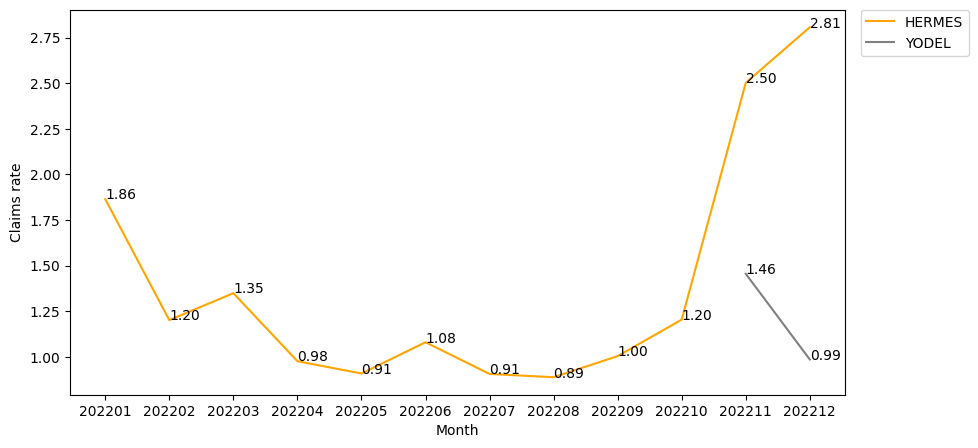

In [81]:
fig, ax = plt.subplots(figsize=(10,5))
ax=sns.lineplot(data=df3, x="sk_month", y="claims_rate",hue='carriers',errorbar=None,palette=["orange", "gray"])
ax.set_ylabel('Claims rate')    
ax.set_xlabel('Month')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0) 
    # label points on the plot
for x, y in zip(df3['sk_month'], df3['claims_rate']):
    plt.text(x = x, y = y,s='{0:.2f}'.format(y),color = 'black')
plt.show()

In [104]:
group_country_uk=df[df['country_code']=='GB']
group_country_uk['city']=group_country_uk['city'].str.upper()
group_country_uk['ZIP']=group_country_uk['ZIP'].str.upper()
group_country_uk

/tmp/ipykernel_1796/1580973332.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1796/1580973332.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,number_of_claims,claims_amount,country_code,sk_month,carrier,ZIP,city,unplanned_return_flag,reconditioned_claim_flag
10,1,389.76,GB,202212,HERMES,CH63 1JQ,WIRRAL,0,0
41,1,135.33,GB,202202,HERMES,UB5 4RU,NORTHOLT,0,0
42,1,70.30,GB,202208,HERMES,BL3 3JX,BOLTON,0,1
54,1,110.20,GB,202212,HERMES,UB8 6GH,LONDON,0,0
62,1,178.50,GB,202211,HERMES,RM8 2RP,DAGENHAM,0,0
...,...,...,...,...,...,...,...,...,...
272415,1,73.23,GB,202201,HERMES,TW5 0BY,HOUNSLOW,0,0
272420,1,47.57,GB,202206,HERMES,CM22 7AS,HATFIELD HEATH,0,0
272436,1,99.26,GB,202202,HERMES,RM9 4PA,DAGENHAM,0,0
272437,1,436.53,GB,202203,HERMES,N9 8QE,LONDON,0,0


In [107]:
group_country_uk=group_country_uk.groupby(['city','ZIP'], as_index=True).agg({'number_of_claims':sum})
group_country_uk.sort_values(['ZIP'])
group_country_uk=group_country_uk.reset_index()
group_country_uk

,city,ZIP,number_of_claims
0,"ABBEY HEY, MANCHESTER",M18 8RH,1
1,ABBEYMEAD,GL4 4SD,1
2,ABBEYMEAD,GL4 5TA,1
3,"ABBEYMEAD, GLOUCESTER",GL4 5UQ,1
4,ABBOTS LANGLEY,WD5 0DH,1
...,...,...,...
14873,YORK,YO26 5AU,1
14874,YORK,YO26 5RX,1
14875,YORK,YO30 6NB,1
14876,YORK,YO31 7YB,1


In [110]:
import pandas as pd
import pandas_bokeh
import matplotlib.pyplot as plt
import pgeocode
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

import plotly.graph_objects as go
## Adding some dummy data 
nomi = pgeocode.Nominatim('gb')

group_country_uk['Latitude'] = (nomi.query_postal_code(group_country_uk['ZIP'].tolist()).latitude)
group_country_uk['Longitude'] = (nomi.query_postal_code(group_country_uk['ZIP'].tolist()).longitude)


In [111]:
group_country_uk

,city,ZIP,number_of_claims,Latitude,Longitude
0,"ABBEY HEY, MANCHESTER",M18 8RH,1,53.466700,-2.166700
1,ABBEYMEAD,GL4 4SD,1,51.827060,-2.187810
2,ABBEYMEAD,GL4 5TA,1,51.827060,-2.187810
3,"ABBEYMEAD, GLOUCESTER",GL4 5UQ,1,51.827060,-2.187810
4,ABBOTS LANGLEY,WD5 0DH,1,51.705200,-0.417300
...,...,...,...,...,...
14873,YORK,YO26 5AU,1,53.966600,-1.193967
14874,YORK,YO26 5RX,1,53.966600,-1.193967
14875,YORK,YO30 6NB,1,54.017950,-1.180125
14876,YORK,YO31 7YB,1,53.957600,-1.082700


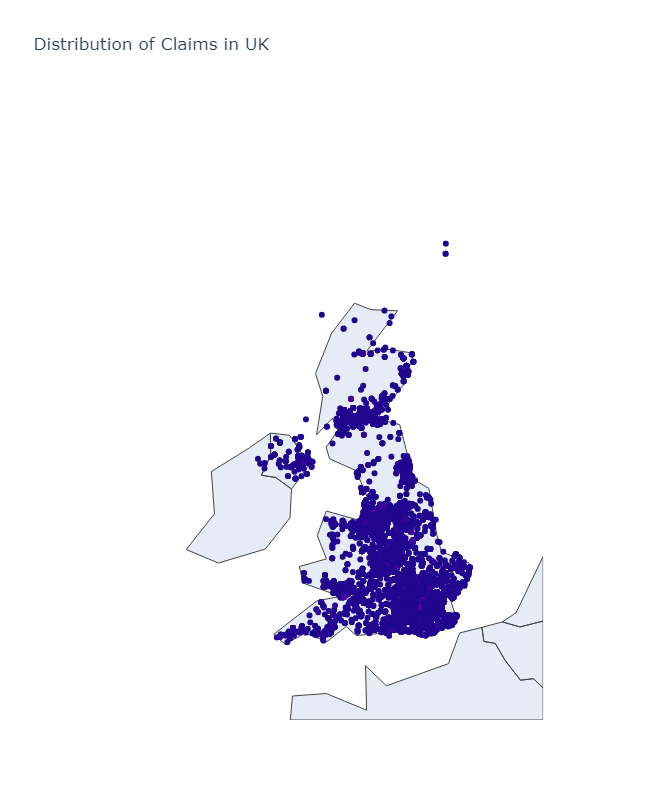

In [130]:
fig = go.Figure(data=go.Scattergeo(
        lon = group_country_uk['Longitude'],
        lat = group_country_uk['Latitude'],
        text = group_country_uk[['city','number_of_claims']],
        mode = 'markers',
        marker_color = group_country_uk['number_of_claims'],
        ))
fig.update_geos(lataxis_range=[ 49, 63], lonaxis_range=[-12,2])
fig.update_layout(
        title = 'Distribution of Claims in UK ',
        geo_scope='europe',
    
    
   autosize=False,
    width=800,
    height=800,)

    
fig.show()